1. ~~First, try to replicate the Cifar10 dataset work.~~
2. **If Step 1 works, try replicating with the demo HDD dataset.**
3. If Step 2 works, write the `train` and `test` functions.

Import necessary libraries

In [1]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Utility functions provided from class

In [4]:
## Utility functions

def load_yolo_labels(label_file):
    """ Load YOLO labels from a file. """
    with open(label_file, 'r') as f:
        labels = f.readlines()
    return [list(map(float, label.strip().split())) for label in labels]

def convert_to_pixel_coordinates(yolo_bbox, image_width, image_height):
    """ Convert YOLO normalized bounding box to pixel coordinates. """
    x_center, y_center, w, h = yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]
    
    # Convert to pixel values
    x_center *= image_width
    y_center *= image_height
    w *= image_width
    h *= image_height
    
    # Calculate the top-left and bottom-right corners
    x1 = x_center - w / 2
    y1 = y_center - h / 2
    x2 = x_center + w / 2
    y2 = y_center + h / 2
    
    return x1, y1, x2, y2

def plot_bounding_boxes(image_path, label_file):
    """ Plot bounding boxes from YOLO label file on an image. """
    # Load image
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape
    
    # Load YOLO labels
    labels = load_yolo_labels(label_file)
    
    # Plot bounding boxes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax = plt.gca()
    
    for label in labels:
        class_id, *bbox = label
        x1, y1, x2, y2 = convert_to_pixel_coordinates(bbox, image_width, image_height)
        
        # Draw the bounding box on the image
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                   linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x1, y1, f'Class {int(class_id)}', color='white', fontsize=12, 
                bbox=dict(facecolor='red', alpha=0.5))
    
    # Display the image
    plt.axis('off')
    # plt.show()

Function to parse YOLO annotations

In [7]:
def parse_yolo_annotations(coord_dir, img_dir, img_size=(640, 640)):
    images = []
    labels = []
    
    for label_file in os.listdir(coord_dir):
        if label_file.endswith(".txt"):
            # Image path
            img_name = label_file.replace(".txt", ".jpg")
            img_path = os.path.join(img_dir, img_name)
            
            if not os.path.exists(img_path):
                continue  # Skip if corresponding image is missing
            
            # Load image and resize
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size) / 255.0  # Normalize pixel values
            images.append(img)
            
            # Load YOLO labels
            yolo_labels = load_yolo_labels(os.path.join(coord_dir, label_file))
            class_ids = [int(label[0]) for label in yolo_labels]  # Extract class IDs
            labels.append(class_ids)
    
    return np.array(images), np.array(labels, dtype=object)

Load Dataset

In [10]:
# Define directories
train_img_dir = "Training Set/Training Images/"
train_coords_dir = "Training Set/Training Coordinates/"
test_img_dir = "Testing Set/Testing Images/"
test_coords_dir = "Testing Set/Testing Coordinates/"

# Load training and testing data
train_images, train_labels = parse_yolo_annotations(train_coords_dir, train_img_dir)
test_images, test_labels = parse_yolo_annotations(test_coords_dir, test_img_dir)

# Convert variable-length label arrays to padded arrays
max_digits = 3  # Maximum number of digits in an image (adjust as needed)
train_labels_padded = pad_sequences(train_labels, maxlen=max_digits, padding='post')
test_labels_padded = pad_sequences(test_labels, maxlen=max_digits, padding='post')

In [12]:
type(train_images)

numpy.ndarray

In [14]:
type(train_labels)

numpy.ndarray

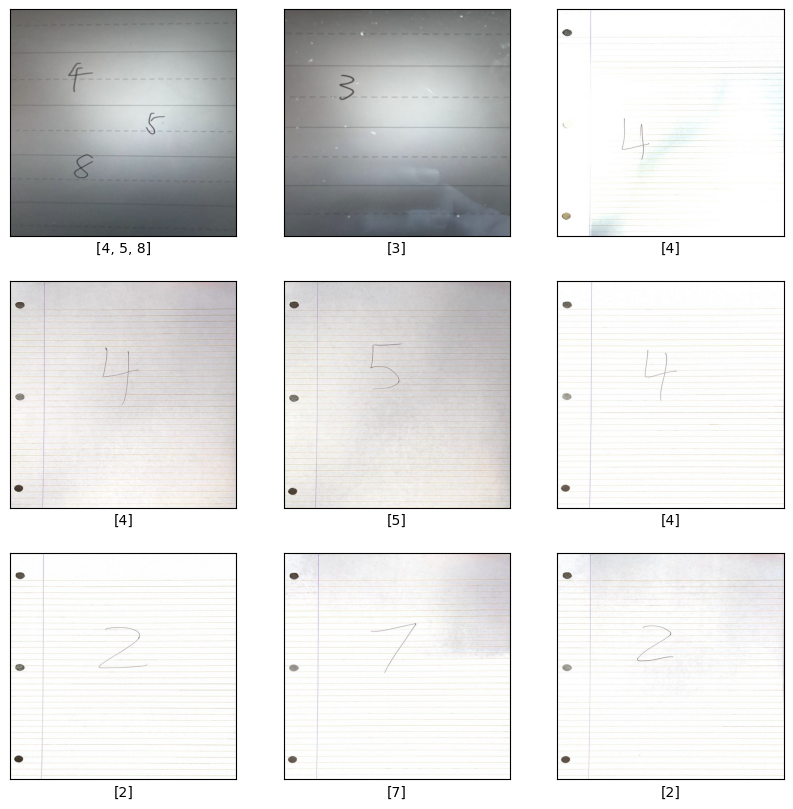

In [16]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

Create the convolutional base

In [18]:
# Understand this from teammates
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 640, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

C:\Users\AsusG14\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 638, 638, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 319, 319, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 317, 317, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 158, 158, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 156, 156, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 78, 78, 128)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

Add Dense layers on top

In [22]:
# Understand this from teammates
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 638, 638, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 319, 319, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 317, 317, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 158, 158, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 156, 156, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 78, 78, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 778752)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      99,680,384 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,773,632 (380.61 MB)

 Trainable params: 99,773,632 (380.61 MB)

 Non-trainable params: 0 (0.00 B)

Compile and train the model

In [28]:
# Output layers for each digit (up to 3 digits)
digit_outputs = [
    layers.Dense(10, activation='softmax', name=f'digit_{i}')  # 10 classes (0–9)
    for i in range(max_digits)
]

# Add each digit's output
for output in digit_outputs:
    model.add(output)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Prepare labels as a dictionary for multi-output
train_labels_dict = {f'digit_{i}': train_labels_padded[:, i] for i in range(max_digits)}
test_labels_dict = {f'digit_{i}': test_labels_padded[:, i] for i in range(max_digits)}

# Train the model
history = model.fit(train_images, train_labels_dict, epochs=10,
                    validation_data=(test_images, test_labels_dict))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0667 - loss: 2.3424 - val_accuracy: 0.1333 - val_loss: 2.3280
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.3340 - val_accuracy: 0.1333 - val_loss: 2.3281
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.3322 - val_accuracy: 0.1333 - val_loss: 2.3283
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.3303 - val_accuracy: 0.1333 - val_loss: 2.3285
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.3285 - val_accuracy: 0.1333 - val_loss: 2.3287
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.3267 - val_accuracy: 0.1333 - val_loss: 2.3288
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.3248 - val_accuracy: 0.1333 - val_loss: 2.3290
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.3230 - val_accuracy: 0.1333 - val_l

Evaluate the model

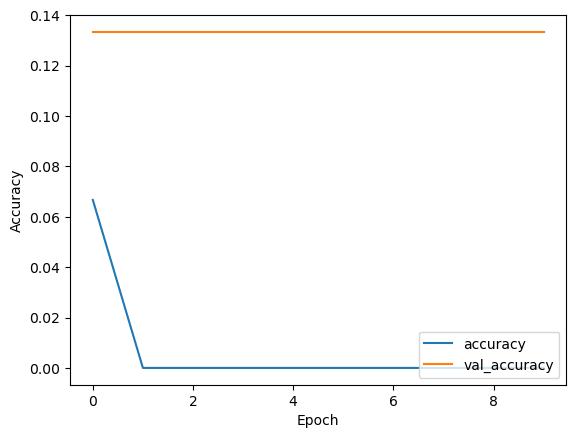

In [32]:
# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
# print(f"Test accuracy: {test_acc}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()